In [2]:
import os
import json

from IPython.display import Image, display
from paddleocr import PaddleOCR,draw_ocr
from tqdm import tqdm
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False, ocr_version="PP-OCRv3", enable_mkldnn=True) # need to run only once to download and load model into memory

[2022/09/14 17:41:11] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/mingyang/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/mingyang/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None,

## Line Table Extraction
In this section, we develop code to extract the data table from the Line Image. 
### Load the Dataset

In [5]:
split = "test2019"
data_path = '/dvmm-filer2/projects/mingyang/semafor/chart_table/data/bar/annotations'
test_data_path = '/'.join([data_path, "instancesBar(1031)_{}.json".format(split)])
image_path = '/dvmm-filer2/projects/mingyang/semafor/chart_table/data/bar/images/{}'.format(split)

with open(test_data_path, 'r') as f:
    test_annotation = json.load(f)
    

In [6]:
print(test_annotation.keys())

dict_keys(['licenses', 'images', 'annotations', 'categories'])


In [7]:
print(type(test_annotation['images']))
print(type(test_annotation['annotations']))
print(type(test_annotation['categories']))

print(len(test_annotation['images']))
print(len(test_annotation['annotations']))

<class 'list'>
<class 'list'>
<class 'list'>
6262
143084


In [8]:
print(test_annotation['images'][0])
print(test_annotation['annotations'][0])
print(test_annotation['categories'][0])

{'file_name': '8763309d9af01abde80aed0d82bd4a97_d3d3LnZvbGtzZ2V6b25kaGVpZGVuem9yZy5pbmZvCTEzMS4yMjQuMjUwLjEyMA==.xls-7-1.png', 'height': 508, 'width': 548, 'id': 0}
{'image_id': 0, 'category_id': 0, 'bbox': [65.0, 399.0, 4.0, 53.0], 'area': 212.0, 'id': 0}
{'supercategory': 'Series', 'id': 0, 'name': 'Series'}


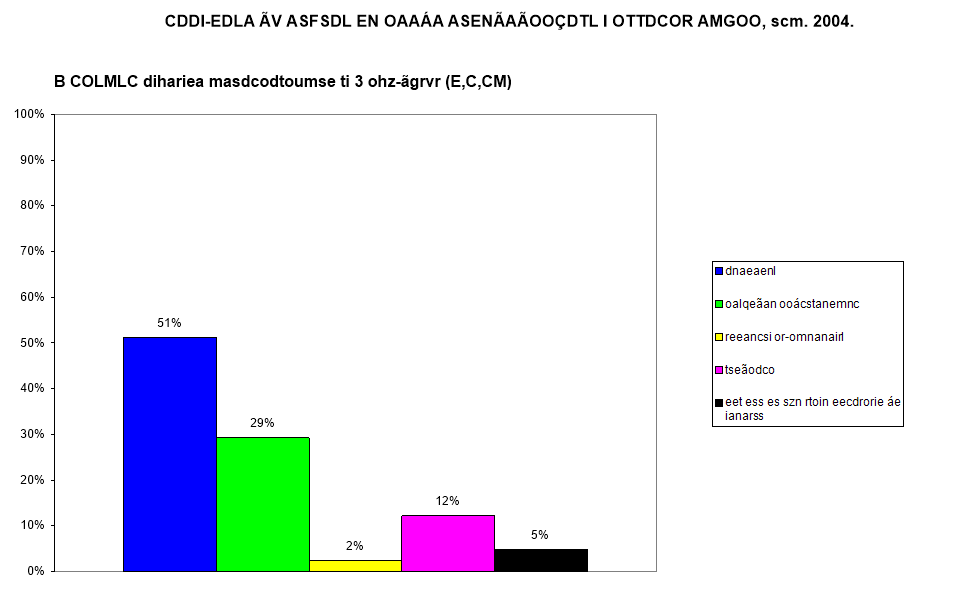

[{'image_id': 1, 'category_id': 0, 'bbox': [124.0, 337.0, 93.0, 234.0], 'area': 21762.0, 'id': 84}, {'image_id': 1, 'category_id': 0, 'bbox': [216.0, 437.0, 93.0, 134.0], 'area': 12462.0, 'id': 85}, {'image_id': 1, 'category_id': 0, 'bbox': [309.0, 560.0, 93.0, 11.0], 'area': 1023.0, 'id': 86}, {'image_id': 1, 'category_id': 0, 'bbox': [401.0, 515.0, 93.0, 56.0], 'area': 5208.0, 'id': 87}, {'image_id': 1, 'category_id': 0, 'bbox': [494.0, 549.0, 93.0, 22.0], 'area': 2046.0, 'id': 88}]


In [10]:
## Line Annotation
#image_info = [x['id']: {'file_name':x['file_name'], 'height':x['height'], 'width':x['width']} for x in test_annotation['images']]
#good sample: [28]
sample_info = test_annotation['images'][1]
sample_id = sample_info['id']
#Find all the annotations:

#Display the image
sample_img_path = '/'.join([image_path, sample_info['file_name']])
display(Image(filename=sample_img_path))

#Map Annotations to Image ID
AnnotationMap = {}
for x in test_annotation['annotations']:
    img_id = x['image_id']
    AnnotationMap[img_id] = AnnotationMap.get(img_id, []) + [x]
    
sample_annotation = AnnotationMap[sample_id]
print(sample_annotation)


### Detect Text Elements of the Image
Extract the Text Elements from Line Image. 

1. **Extract Legend**
    - Disregard the Numerical Values
    - Disregard the bounding box that is not Vertically or Horizontally aligned
    
2. **Extract X-labels**
   - Filter the texts that is above the 1/2 of the height (assume the x-axies is at the bottom)
   - Using sliding line in vertical direction and record the intersected bounding box. 
   - The maximum number of intersection is considered as the x-labels
   
3. **Extract Y-labels** 
   - Filter the texts that is above the 1/2 of the height (assume the y-axies is to the left side)
   - Using sliding line in vertical direction and record the intersected bounding box. 
   - The maximum number of intersection is considered as the y-labels


2. **Extract Title**
    - Detected Text that is closest to the Top. 

In [76]:
#Get the OCR of this image
ocr_dir = "/dvmm-filer2/projects/mingyang/semafor/chart_table/data/line/ocr_results/test2019/{}.json".format(sample_id)
with open(ocr_dir, "r") as f:
    ocr_texts = json.load(f)

print(ocr_texts)

[[[[112.0, 18.0], [319.0, 19.0], [319.0, 34.0], [112.0, 32.0]], ['SW and SPW Nearby Cash Prices', 0.9488018751144409]], [[[38.0, 57.0], [58.0, 57.0], [58.0, 69.0], [38.0, 69.0]], ['550', 0.9381256103515625]], [[[37.0, 83.0], [60.0, 83.0], [60.0, 99.0], [37.0, 99.0]], ['500', 0.9986287951469421]], [[[37.0, 111.0], [60.0, 111.0], [60.0, 126.0], [37.0, 126.0]], ['450', 0.999495267868042]], [[[7.0, 128.0], [22.0, 128.0], [19.0, 197.0], [5.0, 197.0]], ['$imetric ton', 0.9712057709693909]], [[[39.0, 139.0], [60.0, 139.0], [60.0, 153.0], [39.0, 153.0]], ['400', 0.9991295337677002]], [[[435.0, 145.0], [482.0, 145.0], [482.0, 156.0], [435.0, 156.0]], ['PNW SW', 0.9915946125984192]], [[[38.0, 167.0], [59.0, 167.0], [59.0, 181.0], [38.0, 181.0]], ['350', 0.9993664622306824]], [[[435.0, 169.0], [484.0, 169.0], [484.0, 180.0], [435.0, 180.0]], ['GuIfSRW', 0.914030134677887]], [[[38.0, 195.0], [59.0, 195.0], [59.0, 207.0], [38.0, 207.0]], ['300', 0.9998013973236084]], [[[37.0, 221.0], [60.0, 221.0],

In [77]:
import re

def ocr_preprocessing(ocr_texts):
    filtered_ocr_texts = []
    thred = 0.8
    for line in ocr_texts:
        if line[1][1] > thred:
            filtered_ocr_texts.append(line)
    return filtered_ocr_texts

def hv_alignment(a, b):
    #compare the bounding box a and b to check if they are horizontal or vertically aligned
    align_thred = 5
    align_diff = [abs(a[0][0]-b[0][0]), abs(a[0][1]-b[0][1]), abs(a[2][0]-b[1][0]), abs(a[2][1]-b[2][1])]
    if min(align_diff) < align_thred:
        return True
    else:
        return False


#Extract xlabels
def extract_xlabels(ocr_texts, sample_info):
    img_height = int(sample_info['height'])
    #print(img_height)
    x_label_candidates = []
    
    #Only consider the texts under the middle point. 
    starting_point = int(0.5*img_height)
    #moving pace is the min of the bounding box size
    step = int(min([x[0][2][1]-x[0][0][1] for x in ocr_texts]))
    
    intersected_list = []
    for l_pos in range(starting_point, img_height, step):
        #find the intersected texts
        intersected_texts = [x for x in ocr_texts if x[0][0][1] < l_pos and x[0][2][1] > l_pos]
        intersected_list.append(intersected_texts)
    intersected_list = sorted(intersected_list, key=len)
    x_label_candidates = intersected_list[-1]   
        
    return x_label_candidates

#Extract ylabels
def extract_ylabels(ocr_texts, sample_info):
    img_width = int(sample_info['width'])
    #print(img_height)
    y_label_candidates = []
    
    #Only consider the texts under the middle point. 
    end_point = int(0.5*img_width)
    #moving pace is the min of the bounding box width
    step = int(min([x[0][2][0]-x[0][0][0] for x in ocr_texts]))
    
    intersected_list = []
    for l_pos in range(0, end_point, step):
        #find the intersected texts
        intersected_texts = [x for x in ocr_texts if x[0][0][0] < l_pos and x[0][2][0] > l_pos]
        intersected_list.append(intersected_texts)
    intersected_list = sorted(intersected_list, key=len)
    y_label_candidates = intersected_list[-1]  
    #Get rid of y_labels that are not numbers
    final_y_label_candidates = []
    for y_label in y_label_candidates:
        try:
            y_label_text = y_label[1][0]
            y_label_value = float(y_label[1][0])
            final_y_label_candidates.append(y_label)
        except:
            continue
        
    return final_y_label_candidates
def estimate_range(y_labels):
    """
    Make sure the order of the value is following the order of the position. 
    """
    #sorted(intersected_list, key=len)(key=x[0][0][1])
    y_labels.sort(key=lambda x: x[0][0][1])
    
    y_max = max([float(y[1][0]) for y in y_labels])
    y_max_candidate = float(y_labels[0][1][0])
    while y_max != y_max_candidate:
        #pop the first item
        del y_labels[0]
        y_max = max([float(y[1][0]) for y in y_labels])
        y_max_candidate = float(y_labels[0][1][0])
    y_max_pos = 0.5*(y_labels[0][0][0][1]+y_labels[0][0][2][1])
    
    y_min = min([float(y[1][0]) for y in y_labels])
    y_min_candidate = float(y_labels[-1][1][0])
    while y_min != y_min_candidate:
        #pop the first item
        del y_labels[-1]
        y_min = min([float(y[1][0]) for y in y_labels])
        y_min_candidate = float(y_labels[-1][1][0])
    y_min_pos = 0.5*(y_labels[-1][0][0][1]+y_labels[-1][0][2][1])
    
    #y_values = [float(y[1][0]) for y in y_labels]
    y_scale = (y_max - y_min)/(0.5*(y_labels[-1][0][0][1]+y_labels[-1][0][2][1]) - 0.5*(y_labels[0][0][0][1]+y_labels[0][0][2][1]))
    return y_max, y_min, y_scale, y_max_pos, y_min_pos

#Extract Legend
def extract_legend(ocr_texts):
    numerical_pattern = "(\d+(\.\d+))"

    #Step 1, Get rid of Numerical Value
    legend_candidates = []
    for candidate in ocr_texts:
        candidate_text = candidate[1][0]
        if not re.search(numerical_pattern, candidate_text):
            legend_candidates.append(candidate)

    #print(legend_candidates)
    #Step 2, Group Text based on their Vertical or Horizontal Alignment.
    align_map = {}
    for i_a,c_a in enumerate(legend_candidates):
        align_map[i_a] = []
        i_b = i_a+1
        for c_b in legend_candidates[i_a+1:]:
            if hv_alignment(c_a[0],c_b[0]):
                align_map[i_a].append(i_b)
            i_b +=1
    
    legend_groups = []
    legend_group = []

    for k,v in align_map.items():
        if k in legend_group:
            continue
        if v:
            legend_group += v + [k]
            for x in v:
                legend_group += align_map[x]
            legend_group = list(set(legend_group))
            legend_groups.append(legend_group)
            legend_group = []
    if len(legend_groups) == 0:
        return []
    #Get the final legends
    if len(legend_groups) == 1 and len(legend_groups[0]) > 0:
        return [legend_candidates[x] for x in legend_groups[0]]
    else:
        #Pick the one with the maximum elements or maybe the group that has the mapped elements as the gt sectors
        legend_groups.sort(key=len)
        return [legend_candidates[x] for x in legend_groups[-1]]

def expand_legend_box(detected_legends):
    #Assume the mark is to the left
    for c_legend in detected_legends:
        width = c_legend[0][2][0]-c_legend[0][0][0]
        expand_width = int(0.2*width)
        c_legend[0][0][0] -= expand_width
        c_legend[0][3][0] -= expand_width
        
ocr_texts = ocr_preprocessing(ocr_texts)
#Get the x__labels
x_labels = extract_xlabels(ocr_texts, sample_info)

#Get the y_labels
#print("\n")
y_labels = extract_ylabels(ocr_texts, sample_info)
#print(y_labels)
#Estimate the Data Range Value
y_max, y_min, y_scale, y_max_pos, y_min_pos= estimate_range(y_labels)

#Get the legends
filtered_ocr_texts = []
for c_ocr in ocr_texts:
    if c_ocr in x_labels or c_ocr in y_labels:
        continue
    filtered_ocr_texts.append(c_ocr)

detected_legends = extract_legend(filtered_ocr_texts)

print(detected_legends)
#Augment the length of detected_legends
expand_legend_box(detected_legends)

print(detected_legends)

[[[[435.0, 145.0], [482.0, 145.0], [482.0, 156.0], [435.0, 156.0]], ['PNW SW', 0.9915946125984192]], [[[435.0, 169.0], [484.0, 169.0], [484.0, 180.0], [435.0, 180.0]], ['GuIfSRW', 0.914030134677887]]]
[[[[426.0, 145.0], [482.0, 145.0], [482.0, 156.0], [426.0, 156.0]], ['PNW SW', 0.9915946125984192]], [[[426.0, 169.0], [484.0, 169.0], [484.0, 180.0], [426.0, 180.0]], ['GuIfSRW', 0.914030134677887]]]


### Read Data Values
In this step, we compute the value of each point based on its locations compared tot he y_min

In [78]:
import math

# def determinant(v1, v2):
#   return v1[0]*v2[1] - v1[1]*v2[0]

# def dotproduct(v1, v2):
#   return sum((a*b) for a, b in zip(v1, v2))

# def length(v):
#   return math.sqrt(dotproduct(v, v))

# def angle(v1, v2):
#   return math.atan2(determinant(v1,v2), dotproduct(v1, v2))

def compute_unit(p1,p2):
    distance = [p1[0] - p2[0], -(p1[1] - p2[1])]
    norm = math.sqrt(distance[0] ** 2 + distance[1] ** 2)
    direction = [distance[0] / norm, distance[1] / norm]
    return direction

def compute_distance(p1,p2):
    distance = (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
    return distance
    

for line in sample_annotation:
    line_pts = [(line['bbox'][i],line['bbox'][i+1])for i in range(0,len(line['bbox']),2)]
    line_values = [0]*len(line_pts)
    for i,pt in enumerate(line_pts):
        pt_value = y_scale*(y_min_pos - pt[1]) + y_min
        line_values[i] = pt_value
    line['values'] = line_values


### Map the Legend or the Column Text
In this final step we will map the legend text or the other detected Text to each line.

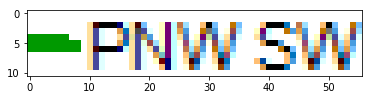

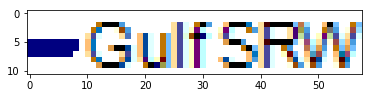

[(387.0, 246.0), (380.0, 243.0), (376.0, 239.0), (370.0, 241.0), (361.0, 246.0), (355.0, 254.0), (348.0, 252.0), (335.0, 252.0), (329.0, 248.0), (322.0, 248.0), (316.0, 250.0), (310.0, 252.0), (303.0, 248.0), (297.0, 242.0), (291.0, 234.0), (284.0, 221.0), (278.0, 212.0), (271.0, 210.0), (265.0, 192.0), (258.0, 190.0), (252.0, 191.0), (246.0, 191.0), (239.0, 192.0), (233.0, 190.0), (227.0, 193.0), (220.0, 169.0), (214.0, 169.0), (206.0, 169.0), (201.0, 148.0), (194.0, 148.0), (188.0, 148.0), (182.0, 148.0), (175.0, 148.0), (169.0, 143.0), (162.0, 158.0), (156.0, 158.0), (150.0, 178.0), (143.0, 153.0), (137.0, 127.0), (130.0, 110.0), (124.0, 122.0), (118.0, 143.0), (110.0, 145.0), (105.0, 112.0), (98.0, 112.0), (92.0, 77.0), (86.0, 82.0), (79.0, 82.0), (73.0, 82.0), (66.0, 87.0)]
[(387.0, 256.0), (380.0, 247.0), (376.0, 247.0), (370.0, 251.0), (361.0, 257.0), (355.0, 268.0), (348.0, 269.0), (335.0, 269.0), (329.0, 255.0), (322.0, 266.0), (316.0, 260.0), (310.0, 261.0), (303.0, 257.0), (

In [79]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)
    
    
    #subset out most popular centroid
    #dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    dominant_colors = clt.cluster_centers_
    return list(dominant_colors)

#If Legend Exist and the Length Matched
#if detected_legends and len(detected_legends) == len(sample_annotation):
#Get the dominant Color for each Legends
legends = {}
sample_image = cv2.imread(sample_img_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
for i, dl in enumerate(detected_legends):
    legends[i] = {'bbox': dl[0], 'text': dl[1]}
    start_point = (int(dl[0][0][0]), int(dl[0][0][1]))
    end_point = (int(dl[0][2][0]), int(dl[0][2][1]))
    
    cropped_image = sample_image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
    plt.imshow(cropped_image)
    plt.show()
#     print(cropped_image[5,3])
#     dominant_colors = get_dominant_color(cropped_image, k=3)
#     print(dominant_colors)
    legends[i]['cropped_image'] = cropped_image


#Find the Color for Each Line, locate a center point, assume the legend will be there
for line in sample_annotation:
    line_pts = [(line['bbox'][i],line['bbox'][i+1])for i in range(0,len(line['bbox']),2)]
    line['column_value'] = ["None"]*len(line_pts)
    pick_point = line_pts[int(0.5*len(line_pts))]
    pick_point = (int(pick_point[0]), int(pick_point[1]))
    
    sample_image_hsv = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HSV)
    pick_point_color = sample_image_hsv[pick_point[1],pick_point[0]]
    
    pp_color_min = np.array([max(0, pick_point_color[0]-5),max(50,pick_point_color[1]-10),max(50, pick_point_color[2]-10)], np.uint8)
    pp_color_max = np.array([pick_point_color[0]+5,min(255, pick_point_color[1]+10),min(255, pick_point_color[2]+10)], np.uint8)
    
    line['row_value'] = "None"
    for k, cl in legends.items():
        cl_image = cl["cropped_image"]
        cl_hsv_image = cv2.cvtColor(cl_image, cv2.COLOR_RGB2HSV)
        frame_threshed = cv2.inRange(cl_hsv_image, pp_color_min, pp_color_max)
        

        #might satisty two saturation
        
        if np.count_nonzero(frame_threshed)/(frame_threshed.shape[0]*frame_threshed.shape[1]) > 0.01:
            #Find a Map
            line['row_value'] = cl['text'][0]
            break
     #Map the line column values 
    print(line_pts)
    for i, pt in enumerate(line_pts):
        pt_x = pt[0]
        thred = 5 #maybe set it to the length of the bbox
        for x_label in x_labels:
            x_label_text = x_label[1][0]
            c_x = 0.5*(x_label[0][0][0]+x_label[0][2][0])
            if abs(c_x-pt_x) < thred:
                line['column_value'][i] = x_label_text


        
        
                             
        

                             
    
#plt.imshow('Binary',thresh_img)
#print(sample_annotation)

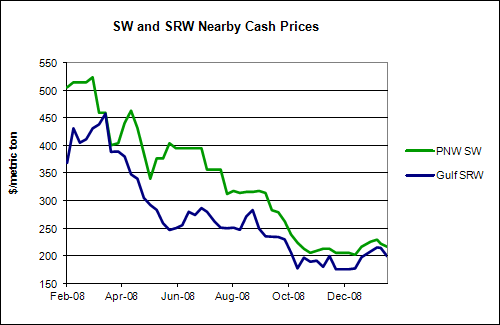

(None,PNW SW): 218.7782805429864
(None,PNW SW): 224.2081447963801
(None,PNW SW): 231.44796380090497
(None,PNW SW): 227.82805429864254
(None,PNW SW): 218.7782805429864
(None,PNW SW): 204.29864253393666
(Dec-08,PNW SW): 207.9185520361991
(None,PNW SW): 207.9185520361991
(None,PNW SW): 215.15837104072398
(None,PNW SW): 215.15837104072398
(None,PNW SW): 211.53846153846155
(None,PNW SW): 207.9185520361991
(None,PNW SW): 215.15837104072398
(None,PNW SW): 226.01809954751133
(O ct-03,PNW SW): 240.4977375565611
(None,PNW SW): 264.02714932126696
(None,PNW SW): 280.31674208144796
(None,PNW SW): 283.9366515837104
(None,PNW SW): 316.5158371040724
(None,PNW SW): 320.1357466063348
(None,PNW SW): 318.32579185520365
(None,PNW SW): 318.32579185520365
(None,PNW SW): 316.5158371040724
(Aug-08,PNW SW): 320.1357466063348
(None,PNW SW): 314.7058823529412
(None,PNW SW): 358.1447963800905
(None,PNW SW): 358.1447963800905
(None,PNW SW): 358.1447963800905
(None,PNW SW): 396.1538461538462
(None,PNW SW): 396.15384

In [81]:
display(Image(filename=sample_img_path))
for result in sample_annotation:
    for c, v in zip(result['column_value'], result['values']):
        print(f"({c},{result['row_value']}): {v}")